# Diabetes Dataset

## Problem List
- Dataset does not match the study protocol -> no information on physical activity
- Insulin Resistance: was imputed (should be categorical/binary, includes 0.301111 for 100 instances)
- BloodSugarLevel:
  - 100 instances were imputed with the mean
  - prevalence of 10 instances of BloodSugarLevel of 70.00000 (=min) 
  - prevalence of 6 instances of 140.00000 (max)
  - Genetic Factor: value of 0.15 in a  categorical/binary column
- Age: spike in people 20 and 80 -> most likely, younger and older people were entered to be that age
- Ethnicity: ethnicity 2 is severely underrepresented in comparision
- BMI: huge spike at 28

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Load your dataset
# Make sure to replace 'your_data.csv' with your actual data file
df = pd.read_csv('diabetes_study_final_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1000 non-null   int64  
 1   Gender             1000 non-null   int64  
 2   Ethnicity          1000 non-null   int64  
 3   BMI                1000 non-null   float64
 4   BloodSugarLevel    1000 non-null   float64
 5   InsulinResistance  1000 non-null   float64
 6   GeneticFactor      1000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 54.8 KB


In [95]:
df.head(10)

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
0,56,0,1,18.303039,91.118631,0.000000,0.00
1,69,0,4,28.052368,108.830756,0.301111,0.00
2,46,1,4,30.947376,91.569805,0.000000,0.00
3,32,1,0,26.874690,98.878487,0.301111,0.00
4,60,1,3,28.052368,90.062769,0.000000,0.00
5,25,1,4,30.063757,114.767044,0.000000,0.00
6,78,1,0,21.749817,117.876767,0.301111,0.00
7,38,0,2,25.883789,101.480691,0.000000,0.00
8,56,0,4,31.177059,105.573570,1.000000,0.15
9,75,0,0,22.982842,83.271129,0.000000,0.00


In this first look, we can already identify the first problem: InsulinResistance, which should be a binary column with values of either 0 or 1, contains values that are neither (specifically: 0.30111 which is the mean!).

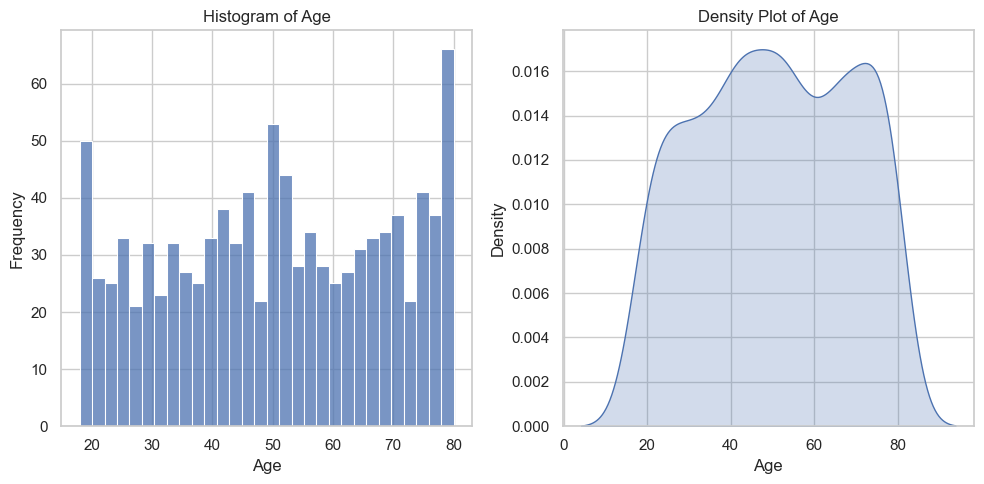

Statistics for Age:
count    1000.000000
mean       50.380000
std        18.378666
min        18.000000
25%        35.000000
50%        50.000000
75%        66.000000
max        80.000000
Name: Age, dtype: float64

Skewness: -0.06131207361588635

Kurtosis: -1.1659864966860534




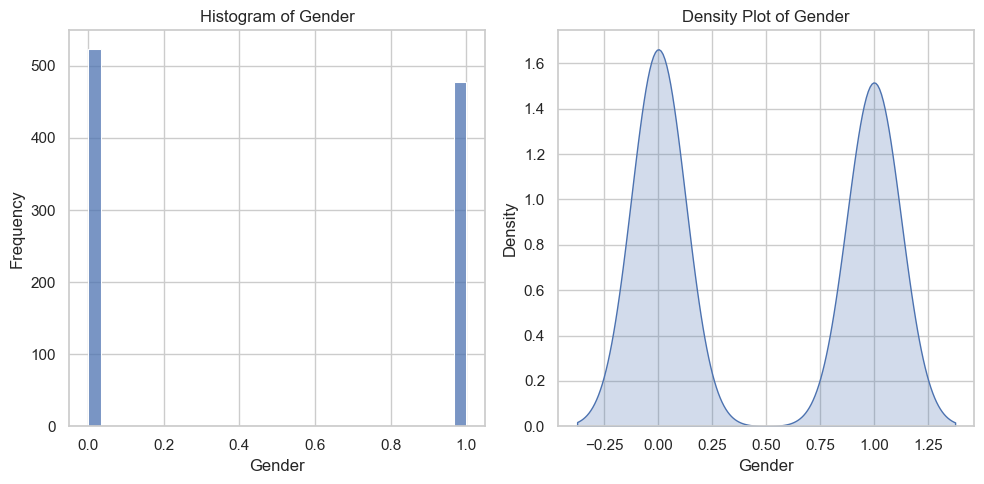

Statistics for Gender:
count    1000.000000
mean        0.477000
std         0.499721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Gender, dtype: float64

Skewness: 0.0922359022863777

Kurtosis: -1.9954875253821587




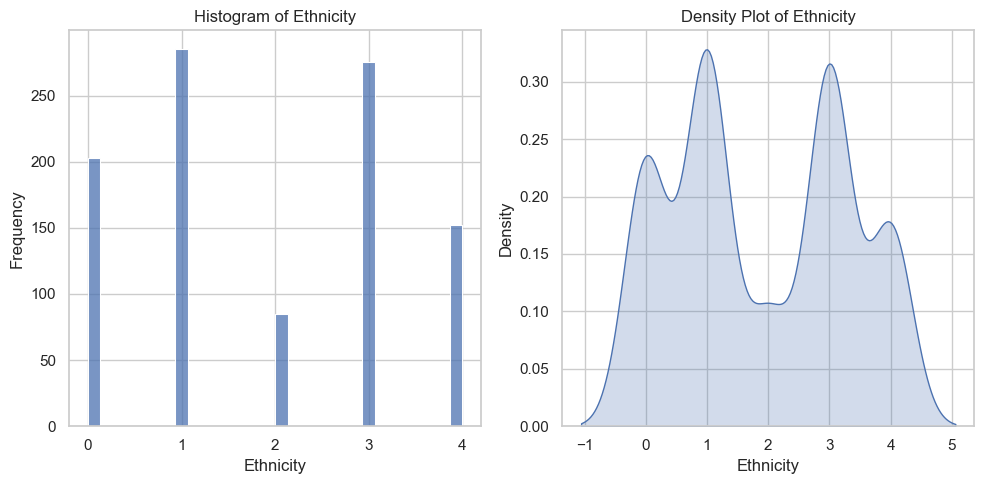

Statistics for Ethnicity:
count    1000.000000
mean        1.888000
std         1.403362
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ethnicity, dtype: float64

Skewness: 0.08871978654083601

Kurtosis: -1.3989569130713262




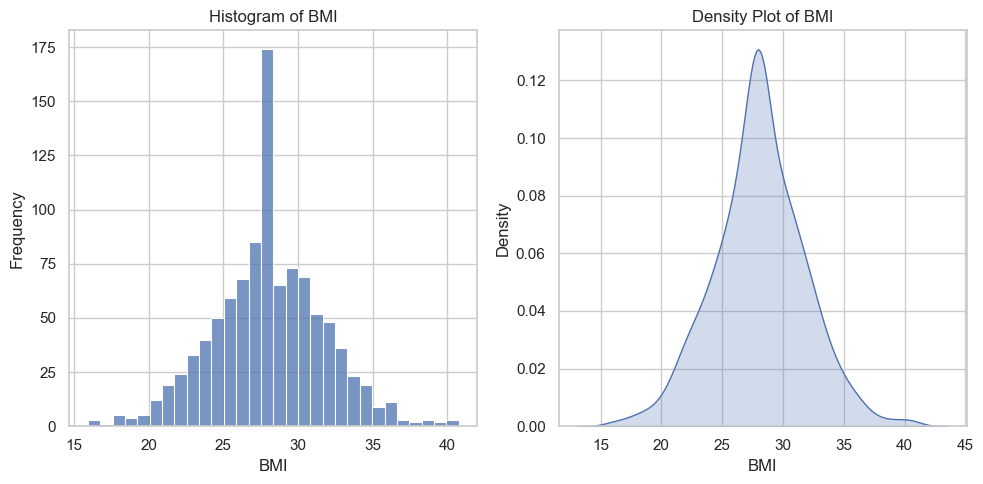

Statistics for BMI:
count    1000.000000
mean       28.052368
std         3.743058
min        15.921951
25%        25.820978
50%        28.052368
75%        30.341792
max        40.772430
Name: BMI, dtype: float64

Skewness: 0.023649854493286382

Kurtosis: 0.550131618874695




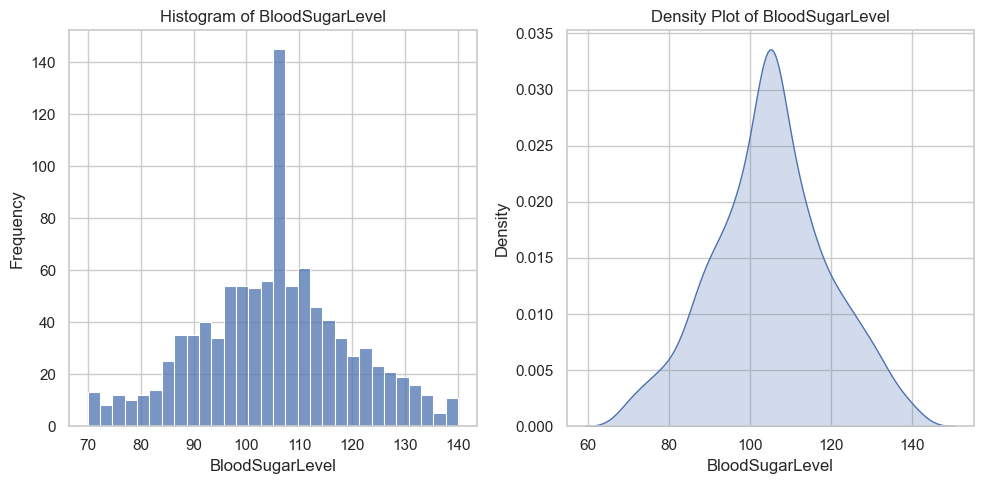

Statistics for BloodSugarLevel:
count    1000.000000
mean      105.053928
std        14.235055
min        70.000000
25%        96.149359
50%       105.053928
75%       113.705994
max       140.000000
Name: BloodSugarLevel, dtype: float64

Skewness: 0.006252079599169542

Kurtosis: -0.11722653334515787




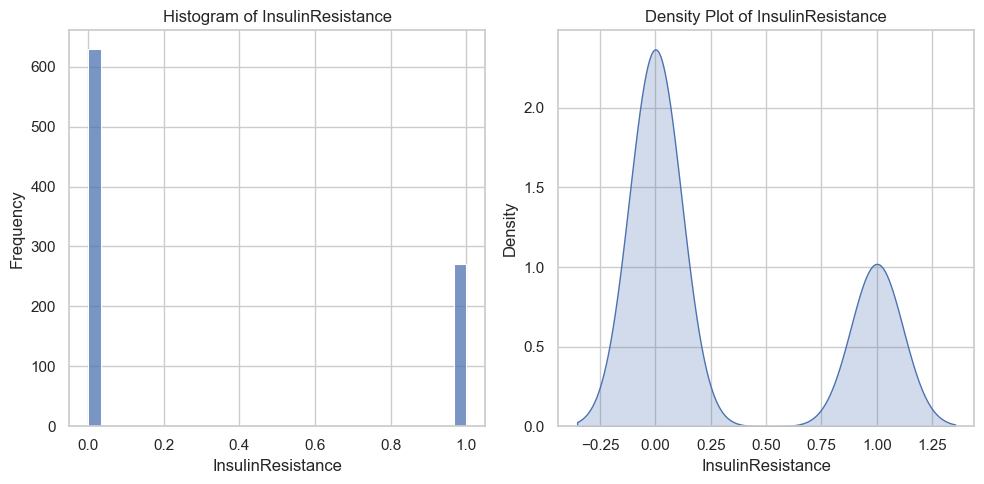

Statistics for InsulinResistance:
count    900.000000
mean       0.301111
std        0.458996
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: InsulinResistance, dtype: float64

Skewness: 0.8685559953091851

Kurtosis: -1.2483896328309474




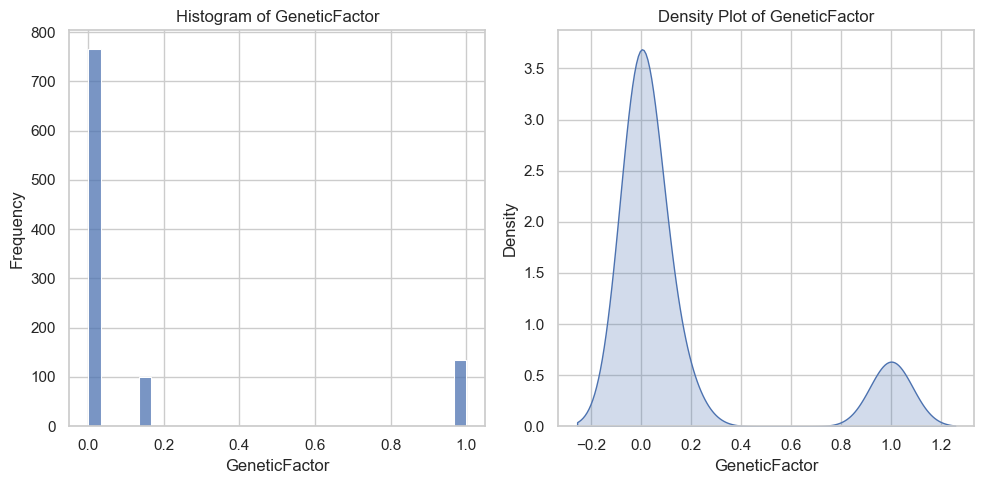

Statistics for GeneticFactor:
count    1000.000000
mean        0.150000
std         0.338917
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: GeneticFactor, dtype: float64

Skewness: 2.069540337802456

Kurtosis: 2.3992370249969546




In [109]:
import seaborn as sns

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions
plot_distributions(df)

Two errors need to be fixed before 

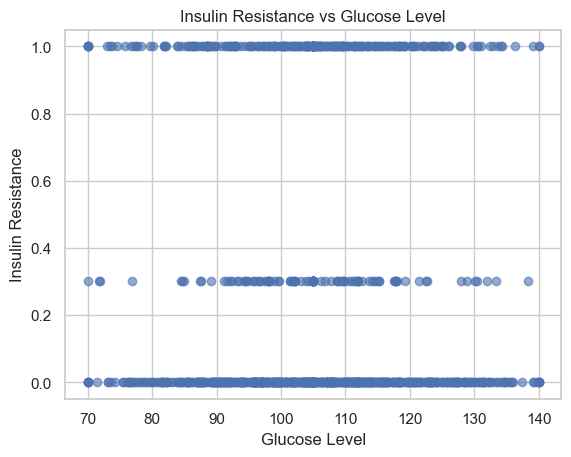

In [97]:
# Plotting the scatter plot
plt.scatter(df['BloodSugarLevel'], df['InsulinResistance'], alpha=0.6)

# Adding labels and title
plt.xlabel('Glucose Level')
plt.ylabel('Insulin Resistance')
plt.title('Insulin Resistance vs Glucose Level')

# Show plot
plt.show()

Now that we know there is an issue with the InsulinResistance column, we replace the mean-imputed values with NaN.

In [98]:
df['InsulinResistance'] = df['InsulinResistance'].apply(lambda x: x if x in [0, 1] else np.nan)


In [99]:


# Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert back to original dtype
df_imputed['InsulinResistance'] = df_imputed['InsulinResistance'].round().astype(int).astype('category')



In [100]:
df_imputed.head(10)

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
0,56.0,0.0,1.0,18.303039,91.118631,0,0.00
1,69.0,0.0,4.0,28.052368,108.830756,0,0.00
2,46.0,1.0,4.0,30.947376,91.569805,0,0.00
3,32.0,1.0,0.0,26.874690,98.878487,0,0.00
4,60.0,1.0,3.0,28.052368,90.062769,0,0.00
5,25.0,1.0,4.0,30.063757,114.767044,0,0.00
6,78.0,1.0,0.0,21.749817,117.876767,0,0.00
7,38.0,0.0,2.0,25.883789,101.480691,0,0.00
8,56.0,0.0,4.0,31.177059,105.573570,1,0.15
9,75.0,0.0,0.0,22.982842,83.271129,0,0.00


In [101]:
print(df["InsulinResistance"].value_counts(dropna=False))
print(df_imputed["InsulinResistance"].value_counts(dropna=False))

InsulinResistance
0.0    629
1.0    271
NaN    100
Name: count, dtype: int64
InsulinResistance
0    712
1    288
Name: count, dtype: int64


# Imputing missing values in the InsulinResistance Column

In [102]:
full_rows = filtered_df = df[df['InsulinResistance'].isin([0, 1])]


In [103]:
# Step 1: Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Separate predictors and target in the training data
X_train = train_df.drop(columns=['InsulinResistance'])
y_train = train_df['InsulinResistance']

# Step 3: Remove rows where y_train is NaN for training the imputation model
X_train_notna = X_train[y_train.notna()]
y_train_notna = y_train[y_train.notna()]

# Check for NaNs in y_train_notna
print("NaNs in y_train_notna:", y_train_notna.isna().sum())

# Ensure y_train_notna contains only 0 or 1
print("Unique values in y_train_notna:", y_train_notna.unique())

# Step 4: Train the model for imputing the categorical column
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_notna, y_train_notna)

NaNs in y_train_notna: 0
Unique values in y_train_notna: [0. 1.]


RandomForestClassifier(random_state=42)

In [104]:
# Step 5: Impute missing values in the training set
missing_mask_train = y_train.isna()
X_train_missing = X_train[missing_mask_train]
if not X_train_missing.empty:
    train_df.loc[missing_mask_train, 'InsulinResistance'] = rf_model.predict(X_train_missing)

# Step 6: Apply the same steps to the test set
X_test = test_df.drop(columns=['InsulinResistance'])
y_test = test_df['InsulinResistance']
missing_mask_test = y_test.isna()
X_test_missing = X_test[missing_mask_test]

if not X_test_missing.empty:
    test_df.loc[missing_mask_test, 'InsulinResistance'] = rf_model.predict(X_test_missing)

# Now the train_df and test_df have imputed values for the 'InsulinResistance' column
print(train_df)
print(test_df)

     Age  Gender  Ethnicity        BMI  BloodSugarLevel  InsulinResistance  \
29    38       0          1  16.314598        98.140475                0.0   
535   75       0          1  23.712571       113.753165                0.0   
695   72       1          0  26.316953       105.053928                0.0   
557   68       1          0  27.235889       129.831107                1.0   
836   40       0          0  28.829069       139.071746                1.0   
..   ...     ...        ...        ...              ...                ...   
106   48       1          0  28.052368       113.284499                1.0   
270   58       0          3  31.812547       128.443332                0.0   
860   22       1          3  27.082437       111.387655                0.0   
435   65       0          0  24.472501        86.373591                1.0   
102   27       0          1  33.187978       111.948094                0.0   

     GeneticFactor  
29            0.00  
535           1.00  


In [105]:
df_combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)

df_combined.describe()

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.380000,0.477000,1.888000,28.052368,105.053928,0.280000,0.150000
std,18.378666,0.499721,1.403362,3.743058,14.235055,0.449224,0.338917
min,18.000000,0.000000,0.000000,15.921951,70.000000,0.000000,0.000000
25%,35.000000,0.000000,1.000000,25.820978,96.149359,0.000000,0.000000
50%,50.000000,0.000000,2.000000,28.052368,105.053928,0.000000,0.000000
75%,66.000000,1.000000,3.000000,30.341792,113.705994,1.000000,0.000000
max,80.000000,1.000000,4.000000,40.772430,140.000000,1.000000,1.000000


In [106]:
df.describe()

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,900.000000,1000.000000
mean,50.380000,0.477000,1.888000,28.052368,105.053928,0.301111,0.150000
std,18.378666,0.499721,1.403362,3.743058,14.235055,0.458996,0.338917
min,18.000000,0.000000,0.000000,15.921951,70.000000,0.000000,0.000000
25%,35.000000,0.000000,1.000000,25.820978,96.149359,0.000000,0.000000
50%,50.000000,0.000000,2.000000,28.052368,105.053928,0.000000,0.000000
75%,66.000000,1.000000,3.000000,30.341792,113.705994,1.000000,0.000000
max,80.000000,1.000000,4.000000,40.772430,140.000000,1.000000,1.000000


This looks like the imputation with random forest for insulin resistance worked and did not affect any other columns (=no mistakes made). 

# BloodSugarLevel
From the distribution of the values in the Histogram, I highly suspect that the values that are 105.053928 were imputed with the mean. The prevalence of 10 instances of BloodSugarLevel of 70.00000 and 6 instances of 140.00000 are most likely invalid as well, as they are the min/max. I want to remove these values and then impute them using KNN Imputation.

In [107]:
df['BloodSugarLevel'].value_counts()

BloodSugarLevel
105.053928    100
70.000000      10
140.000000      6
91.118631       1
88.937214       1
             ... 
96.452506       1
109.942631      1
82.242395       1
116.258688      1
93.648540       1
Name: count, Length: 887, dtype: int64

In [108]:
# Remove imputed values
df_cleaned = df[~df['BloodSugarLevel'].isin([105.053928, 70.000000, 140.000000])]
